In [44]:
import geopandas as gpd
from pathlib import Path
import shapely
from shapely.ops import unary_union
import os
import pandas as pd
import matplotlib as plt

In [45]:
# --- chemins ---
base = Path(r"..\..\Datasets\GeoBoundaries")
dza_shp = base / r"geoBoundaries-3_0_0-DZA-ADM0-all\unzipped\DZA_ADM0_fixedInternalTopology.shp"
tun_shp = base / r"geoBoundaries-3_0_0-TUN-ADM0-all\unzipped\TUN_ADM0_fixedInternalTopology.shp"

out_dir = Path(r"..\..\ExtractedDatasets\GeoBoundaries\AOI_DZA_TUN")
gpkg_out = out_dir / "aoi_dza_tun.gpkg"
geojson_out = out_dir / "aoi_dza_tun.geojson"


In [46]:
# --- lecture ---
dza = gpd.read_file(dza_shp)
tun = gpd.read_file(tun_shp)

In [47]:
# Harmoniser le CRS en WGS84
if dza.crs is None: dza.set_crs("EPSG:4326", inplace=True)
if tun.crs is None: tun.set_crs("EPSG:4326", inplace=True)
dza = dza.to_crs("EPSG:4326")
tun = tun.to_crs("EPSG:4326")

# --- corrections topologiques légères ---
# (buffer(0) = "make valid" simple; pour Shapely>=2, on peut aussi utiliser shapely.make_valid)
dza["geometry"] = dza.buffer(0)
tun["geometry"] = tun.buffer(0)

In [48]:
# --- fusion AOI ---
both = gpd.GeoDataFrame(pd.concat([dza[["geometry"]], tun[["geometry"]]], ignore_index=True), crs="EPSG:4326")
aoi_geom = unary_union(both.geometry.values)  # MultiPolygon unique
aoi = gpd.GeoDataFrame({"name": ["DZA_TUN"], "geometry": [aoi_geom]}, crs="EPSG:4326")

In [49]:
print("gpkg_out:", gpkg_out)
print("abs path:", os.path.abspath(gpkg_out))
parent = os.path.dirname(os.path.abspath(gpkg_out))
print("parent dir:", parent)
print("parent exists:", os.path.exists(parent))
print("parent writable:", os.access(parent, os.W_OK))


gpkg_out: ..\..\ExtractedDatasets\GeoBoundaries\AOI_DZA_TUN\aoi_dza_tun.gpkg
abs path: d:\DataMining\Fire-Detection-Data-Mining-Project\ExtractedDatasets\GeoBoundaries\AOI_DZA_TUN\aoi_dza_tun.gpkg
parent dir: d:\DataMining\Fire-Detection-Data-Mining-Project\ExtractedDatasets\GeoBoundaries\AOI_DZA_TUN
parent exists: True
parent writable: True


In [50]:
# --- exports ---

# Ensure parent directory exists
parent = os.path.dirname(os.path.abspath(gpkg_out))
os.makedirs(parent, exist_ok=True)

# --- write GeoJSON ---
try:
    aoi.to_file(geojson_out, driver="GeoJSON")
    print("Wrote GeoJSON:", geojson_out)
except Exception as e:
    print("Failed to write GeoJSON:", e)

# --- write GPKG (try pyogrio first, then Fiona fallback) ---
try:
    aoi.to_file(gpkg_out, layer="aoi", driver="GPKG")  # default engine (pyogrio)
    print("Wrote GeoPackage:", gpkg_out)
except Exception as e:
    print("pyogrio failed -> trying Fiona. Error:", e)
    try:
        aoi.to_file(gpkg_out, layer="aoi", driver="GPKG", engine="fiona")
        print("Wrote GeoPackage with Fiona:", gpkg_out)
    except Exception as e2:
        print("Failed to write GeoPackage with Fiona:", e2)

print("Bounds (W S E N):", aoi.total_bounds)

Wrote GeoJSON: ..\..\ExtractedDatasets\GeoBoundaries\AOI_DZA_TUN\aoi_dza_tun.geojson
Wrote GeoPackage: ..\..\ExtractedDatasets\GeoBoundaries\AOI_DZA_TUN\aoi_dza_tun.gpkg
Bounds (W S E N): [-8.668909  18.968147  11.997337  37.5422598]
Wrote GeoPackage: ..\..\ExtractedDatasets\GeoBoundaries\AOI_DZA_TUN\aoi_dza_tun.gpkg
Bounds (W S E N): [-8.668909  18.968147  11.997337  37.5422598]


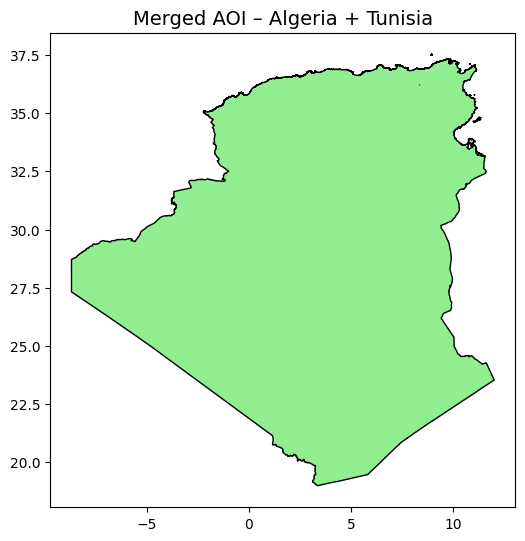

In [51]:
from matplotlib import pyplot as plt

# use the already-defined pathlib.Path gpkg_out (avoids backslash-escape issues)
aoi = gpd.read_file(gpkg_out)

aoi.plot(edgecolor="black", facecolor="lightgreen", figsize=(6, 8))
plt.title("Merged AOI – Algeria + Tunisia", fontsize=14)
plt.show()
